In [1]:
%reload_ext autoreload
%autoreload 2

import jax.numpy as jnp
from utils import *

2024-07-12 11:48:43.377996: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
tcycle = 10 * us
tmax = 10 * s

gamma_min, gamma_max = 0.1 / tmax, 0.5 / tcycle

gammas = jnp.geomspace(gamma_min, gamma_max, 101)
pgammas = jnp.ones_like(gammas) / len(gammas)

C0s = jnp.linspace(0, 1, 101)
pC0s = jnp.ones_like(C0s) / len(C0s)

N = 200
ncycles = jnp.unique(jnp.round(jnp.geomspace(tcycle, tmax, 101) / tcycle).astype(int))

theta = jnp.array(jnp.meshgrid(gammas, C0s, indexing='ij'))
theta = jnp.moveaxis(theta, 0, -1)
ptheta = jnp.prod(jnp.array(jnp.meshgrid(pgammas, pC0s, indexing='ij')), axis=0).astype(
    jnp.float64
)

In [15]:
theta_target = gammas[51], C0s[110]

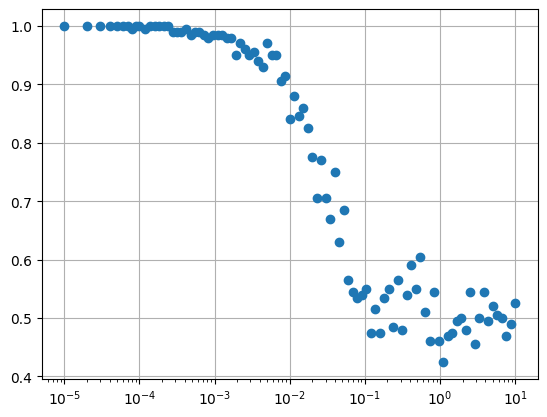

In [17]:
plt.plot(ncycles * tcycle, measure(tcycle * ncycles, theta_target, N, KEY) / N, 'o')
plt.grid()
plt.xscale('log')

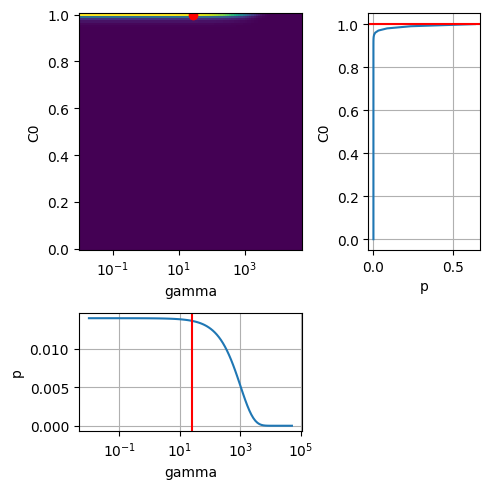

9.999999999999999e-06


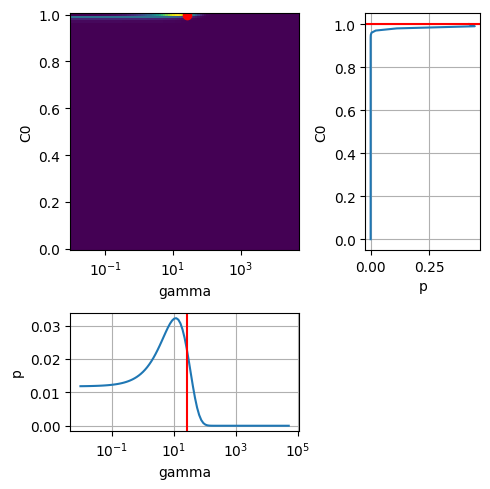

9.999999999999999e-06


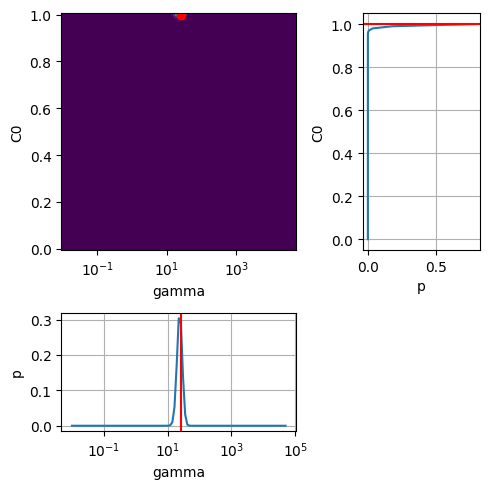

9.999999999999999e-06


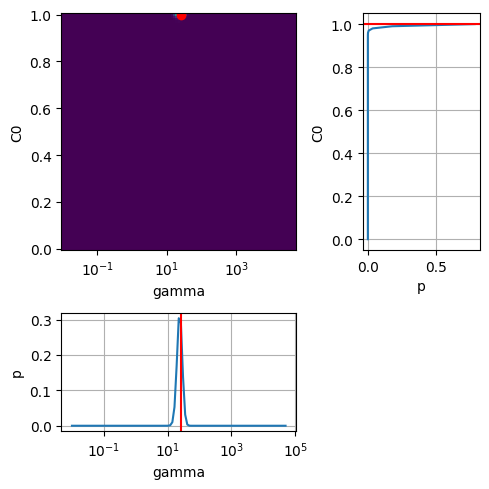

9.999999999999999e-06


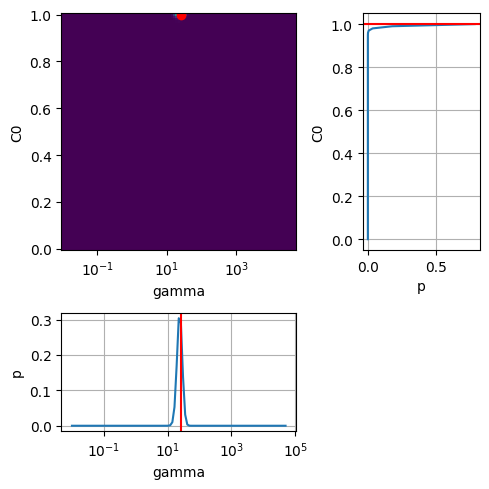

9.999999999999999e-06


In [20]:
theta = jnp.array(jnp.meshgrid(gammas, C0s, indexing='ij'))
theta = jnp.moveaxis(theta, 0, -1)
ptheta = jnp.prod(jnp.array(jnp.meshgrid(pgammas, pC0s, indexing='ij')), axis=0).astype(
    jnp.float64
)

for ind in jnp.linspace(0, len(ncycles), 5).astype(int):
    res = measure(ncycles[ind] * tcycle, theta_target, N, KEY)
    ptheta = update_ptheta(theta, ptheta, res, ncycles[ind] * tcycle, N)
    plot_ptheta(ptheta, theta, theta_target)
    print(optimal_t(tcycle * ncycles, theta, ptheta, N))

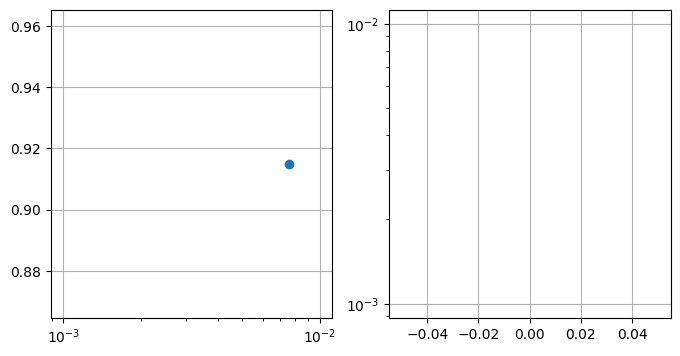

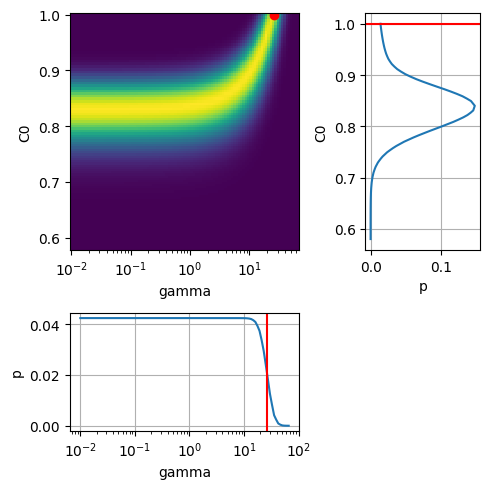

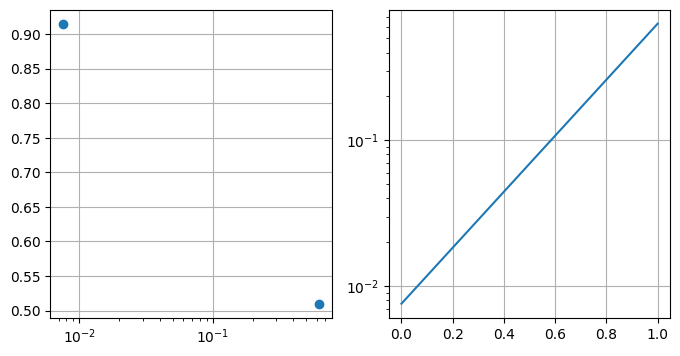

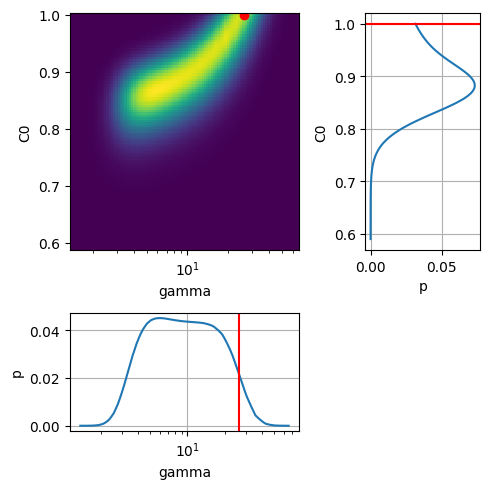

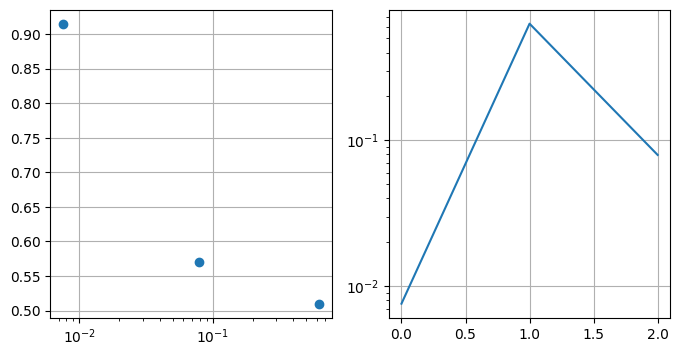

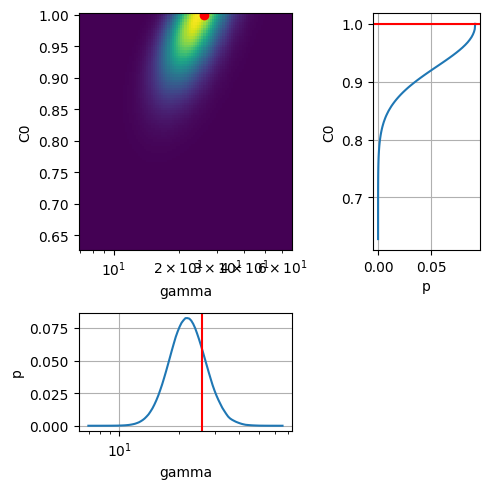

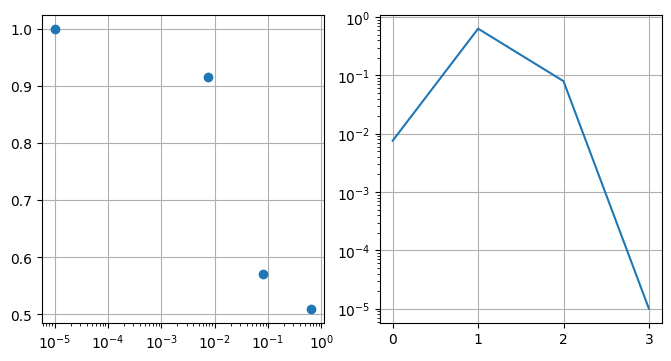

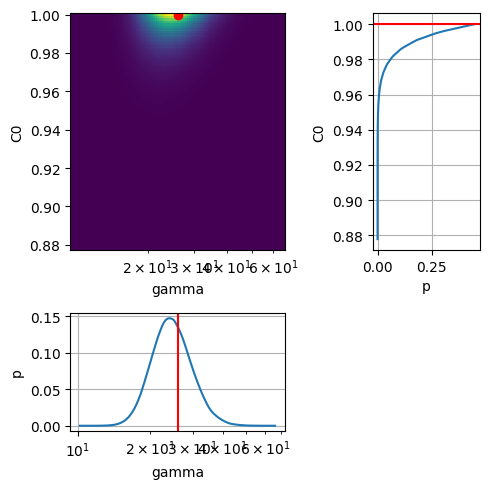

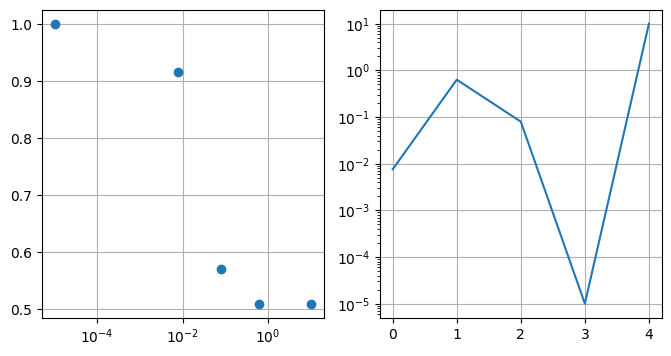

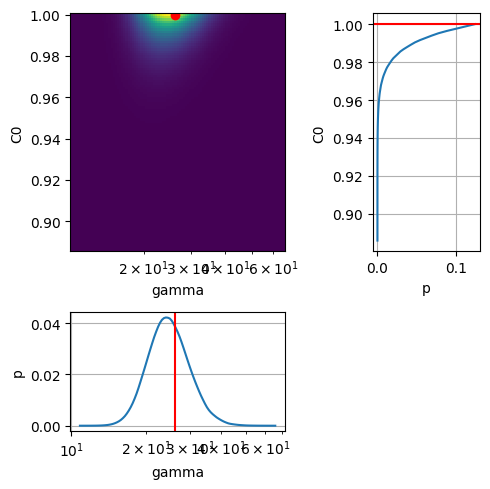

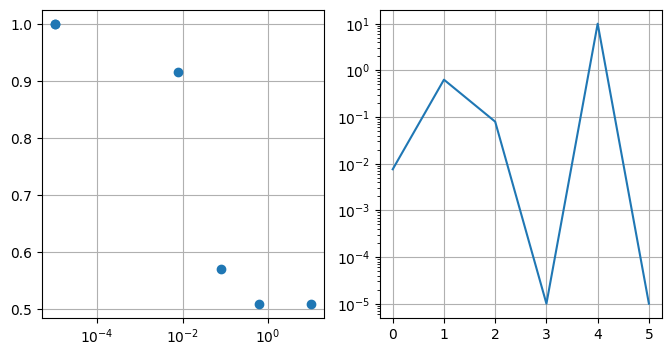

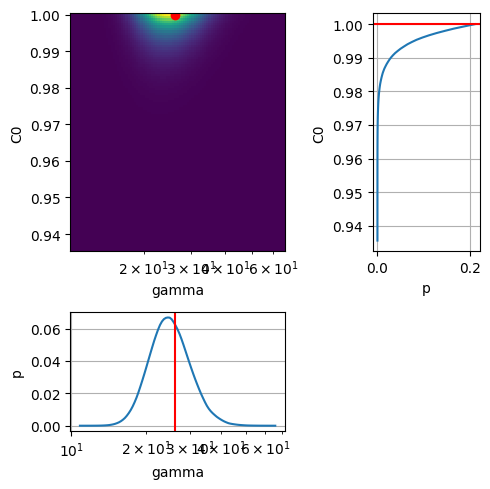

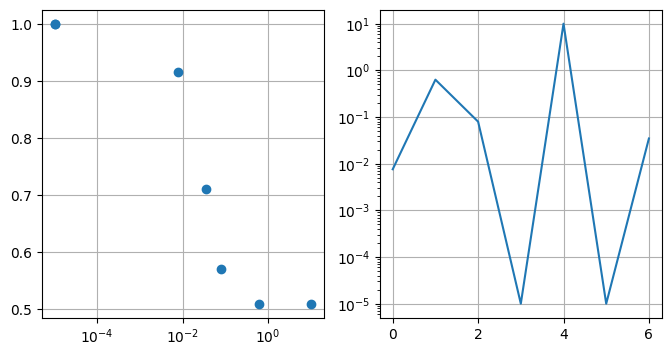

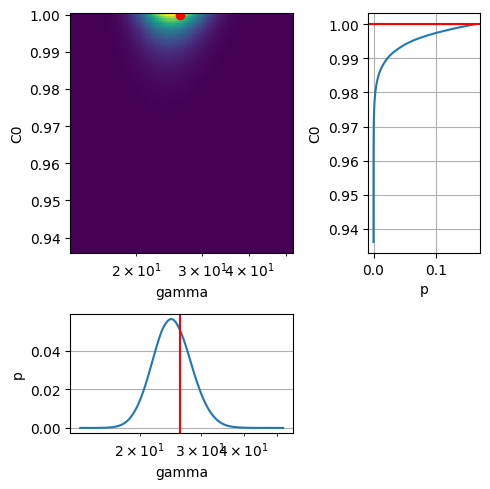

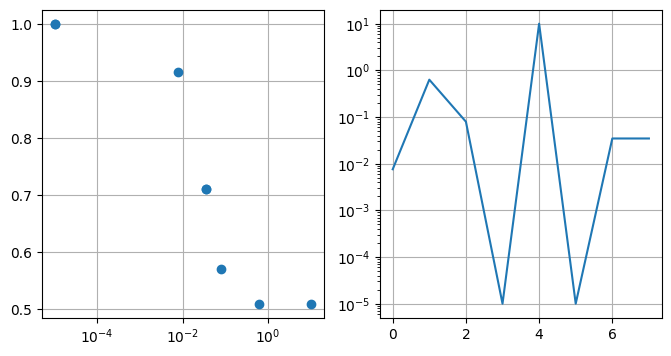

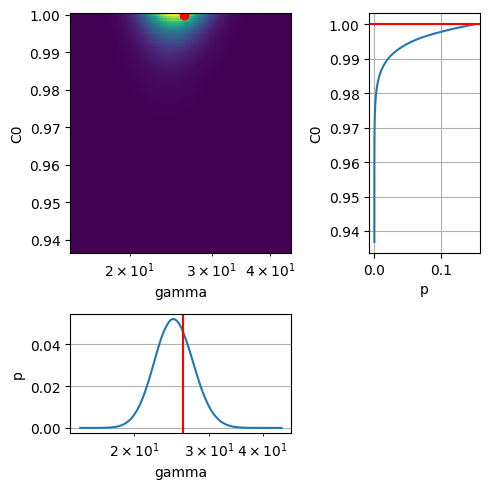

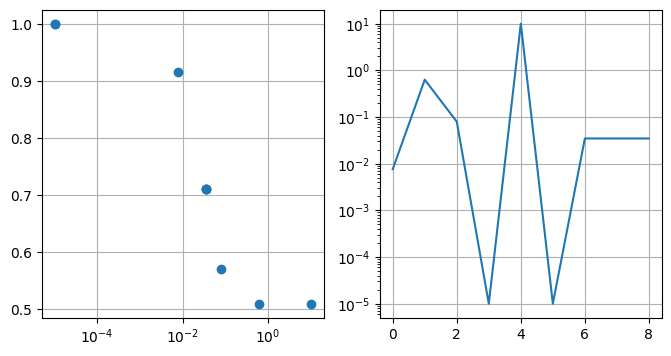

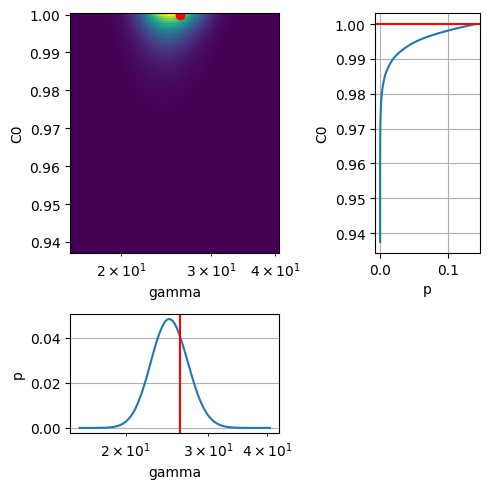

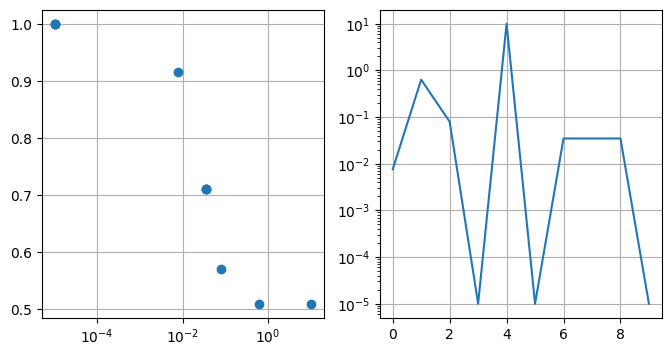

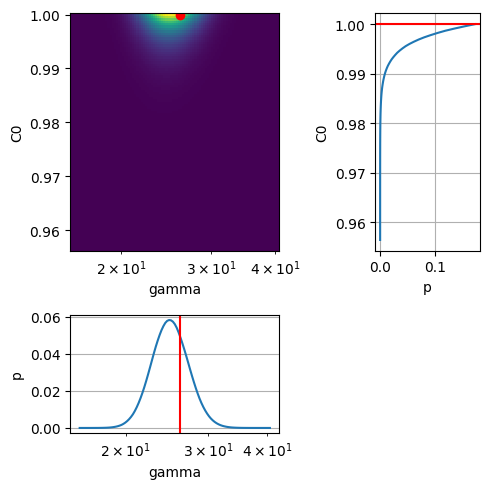

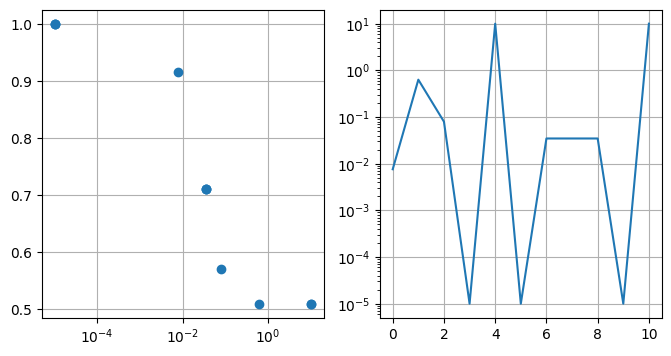

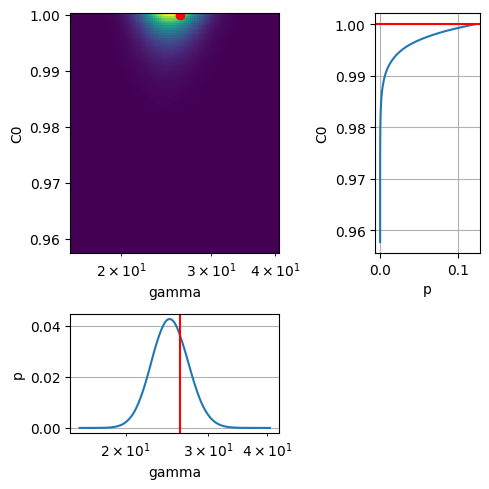

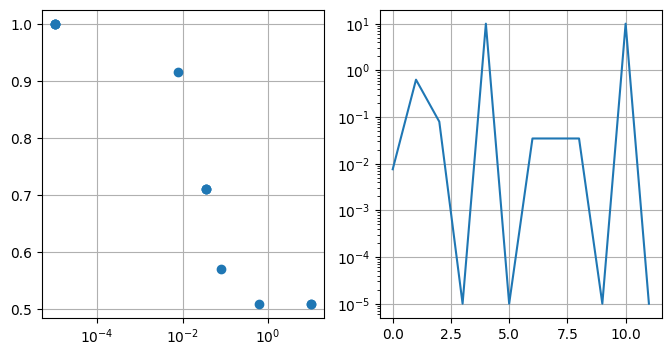

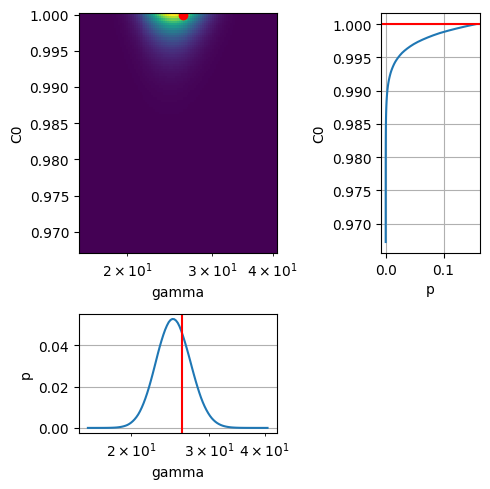

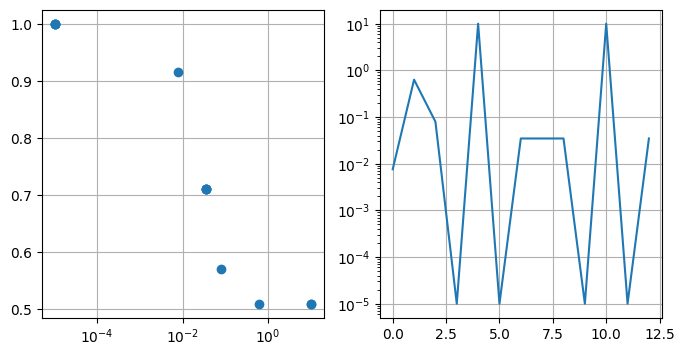

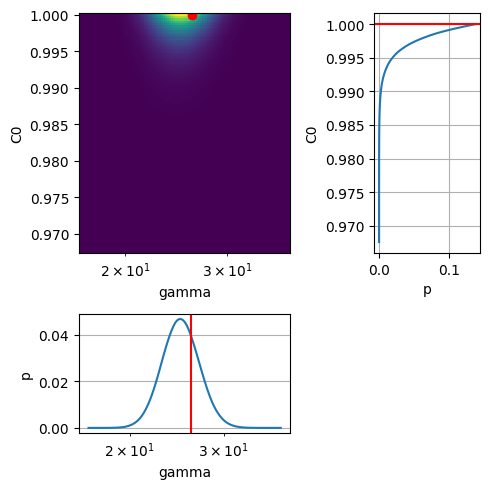

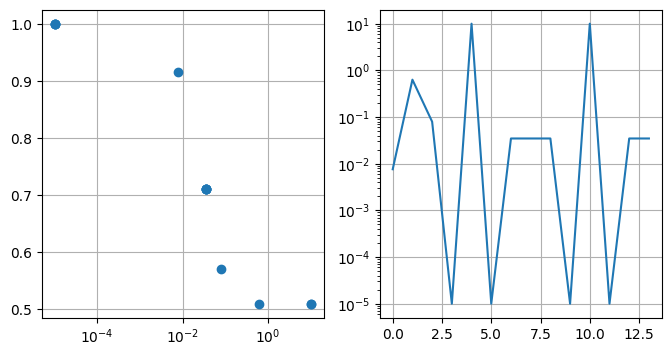

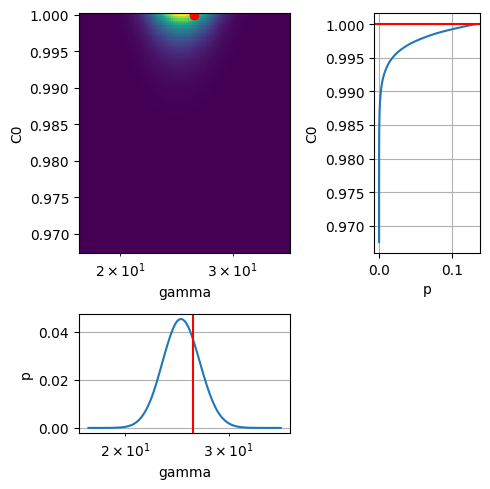

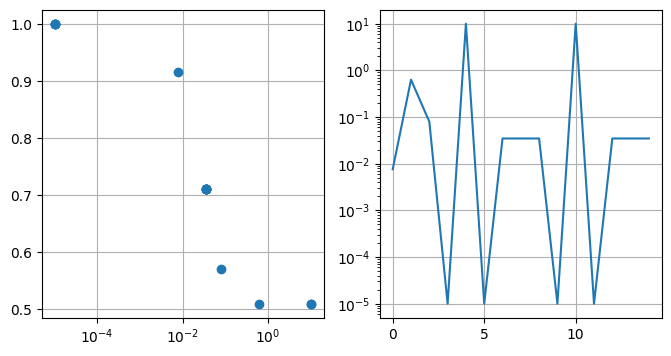

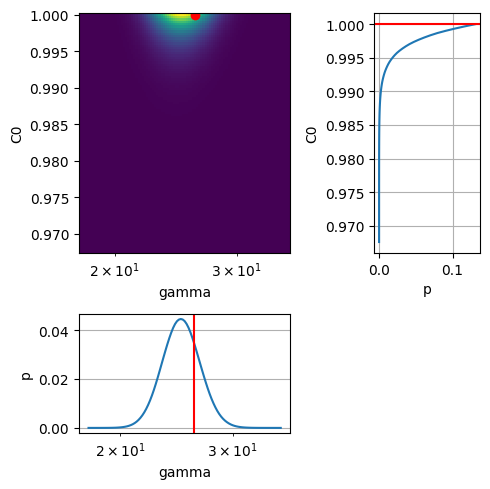

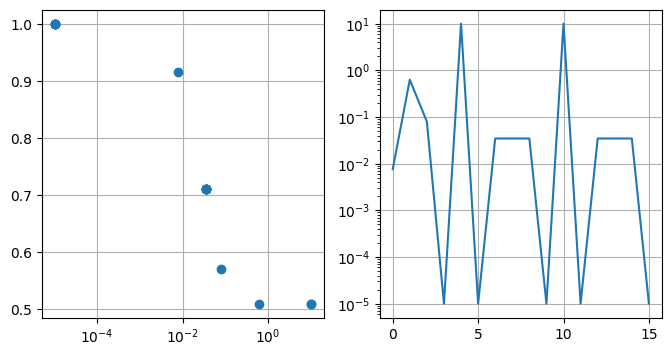

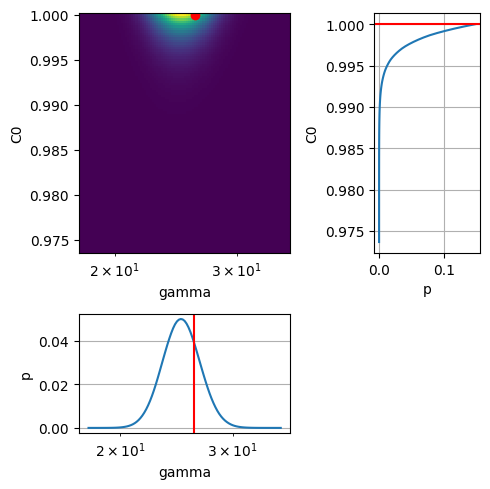

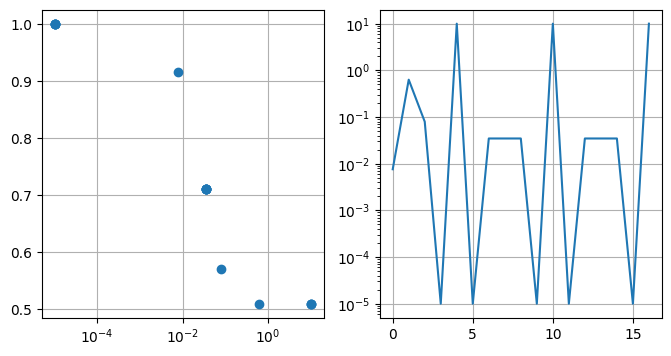

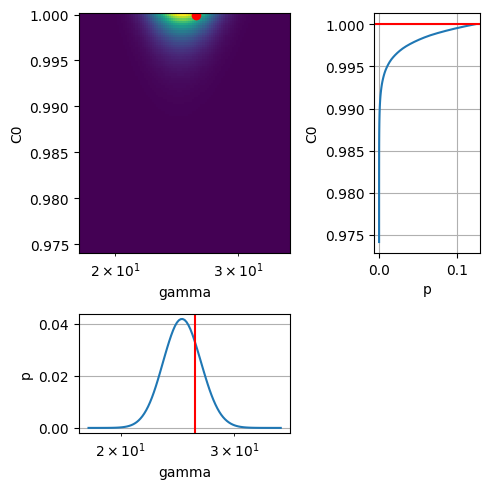

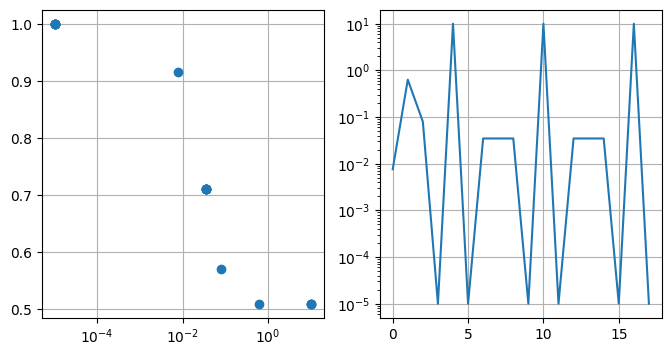

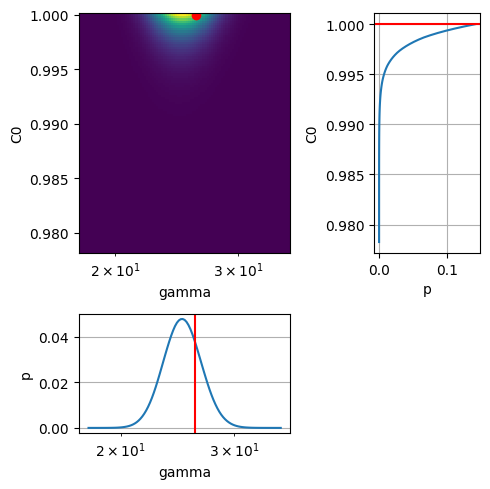

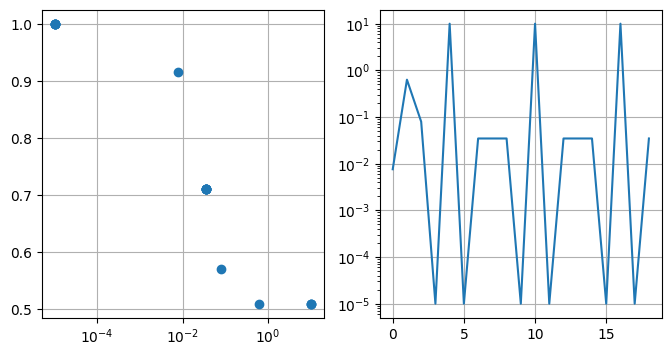

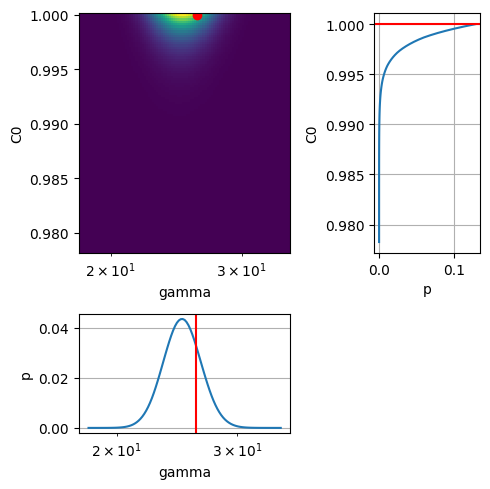

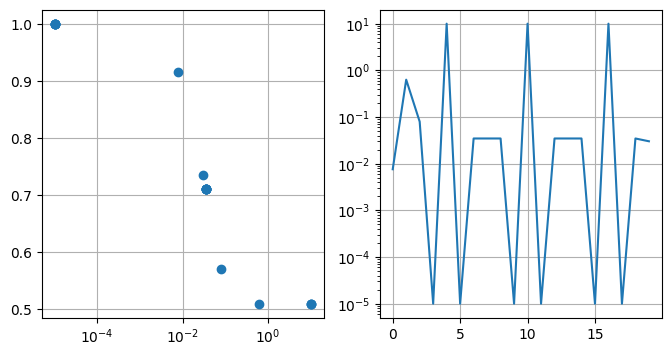

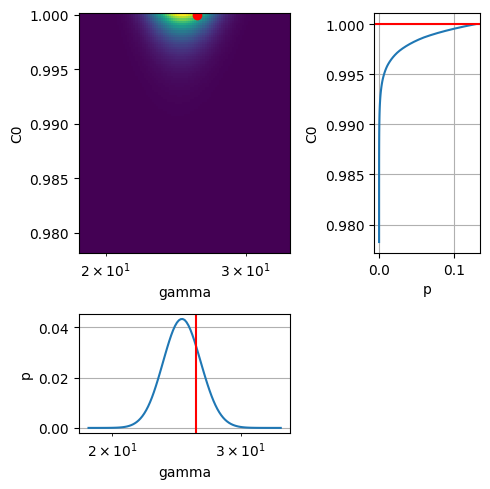

In [21]:
theta = jnp.array(jnp.meshgrid(gammas, C0s, indexing='ij'))
theta = jnp.moveaxis(theta, 0, -1)
ptheta = jnp.prod(jnp.array(jnp.meshgrid(pgammas, pC0s, indexing='ij')), axis=0).astype(
    jnp.float64
)

n_it = 20
t0 = 1 / theta_target[0] / 5
t = ncycles[jnp.argmin(jnp.abs(t0 - ncycles * tcycle))] * tcycle

t_meased = []
k_meased = []

for i in range(n_it):
    res = measure(t, theta_target, N, KEY)
    t_meased.append(t)
    k_meased.append(res / N)

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].plot(t_meased, k_meased, 'o')
    ax[0].set_xscale('log')
    ax[0].grid()

    ax[1].plot(t_meased)
    ax[1].set_yscale('log')
    ax[1].grid()
    plt.show()

    ptheta = update_ptheta(theta, ptheta, res, t, N)
    theta, ptheta = check_and_refine_theta(theta, ptheta)
    plot_ptheta(ptheta, theta, theta_target)
    t = optimal_t(tcycle * ncycles, theta, ptheta, N)

In [ ]:
theta.shape

(101, 101, 2)

In [ ]:
thr = 1e-8
gamma_thr = jnp.any(ptheta > thr, axis=1)
ind_gamma_min = jnp.argmax(gamma_thr)
ind_gamma_max = len(gamma_thr) - jnp.argmax(gamma_thr[::-1]) - 1

C0_thr = jnp.any(ptheta > thr, axis=0)
ind_C0_min = jnp.argmax(C0_thr)
ind_C0_max = len(C0_thr) - jnp.argmax(C0_thr[::-1]) - 1

new_gamma = jnp.geomspace(
    theta[ind_gamma_min, 0, 0], theta[ind_gamma_max, 0, 0], theta.shape[0]
)
new_C0 = jnp.geomspace(theta[0, ind_C0_min, 1], theta[0, ind_C0_max, 1], theta.shape[1])
new_theta = jnp.array(jnp.meshgrid(new_gamma, new_C0, indexing='ij'))
new_theta = jnp.moveaxis(new_theta, 0, -1)

interp = jax.scipy.interpolate.RegularGridInterpolator(
    (
        theta[ind_gamma_min : ind_gamma_max + 1, 0, 0],
        theta[0, ind_C0_min : ind_C0_max + 1, 1],
    ),
    ptheta[ind_gamma_min : ind_gamma_max + 1, ind_C0_min : ind_C0_max + 1],
    method='linear',
    bounds_error=False,
    fill_value=None,
)

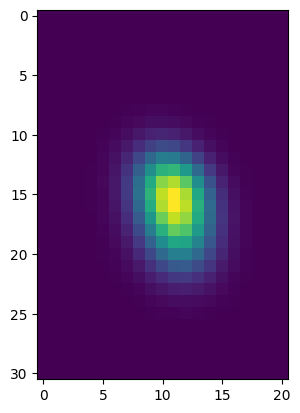

In [ ]:
plt.imshow(ptheta[ind_gamma_min:ind_gamma_max, ind_C0_min:ind_C0_max])

In [ ]:
pts = jnp.array(jnp.meshgrid(new_gamma, new_C0, indexing='ij')).reshape(-1, 2)
new_ptheta = interp(tuple(jnp.meshgrid(new_gamma, new_C0, indexing='ij')))

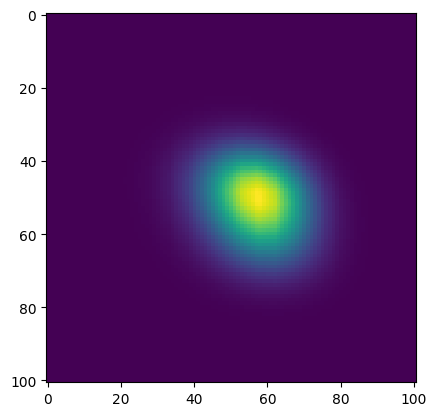

In [ ]:
plt.imshow(new_ptheta)

# Sampled PDf

In [1]:
%reload_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
from sampled_pdf import SampledPDF

In [2]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
# uni = jax.random.uniform(subkey, shape=(50_000,))
uni = jax.random.normal(subkey, shape=(50_000,))
gammas = uni  # 1e-5 * jnp.exp(uni*jnp.log(10/1e-5))
key, subkey = jax.random.split(key)
# C0s = jax.random.uniform(subkey, shape=(50_000,))
C0s = jax.random.normal(subkey, shape=(50_000,))

2024-07-12 11:48:53.882887: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


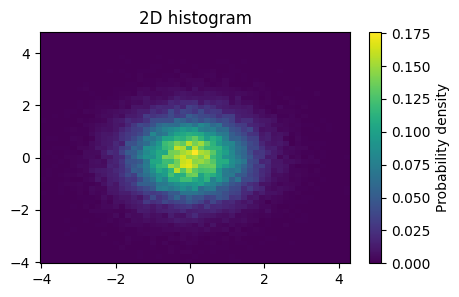

In [3]:
pdf = SampledPDF((gammas, C0s))
pdf.plot()

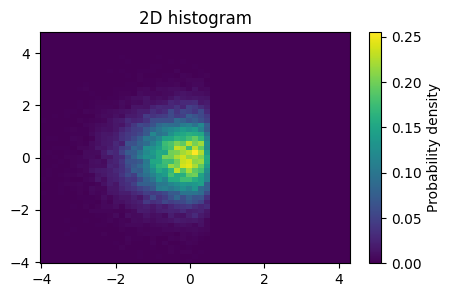

In [4]:
pdf.sample_weights = (pdf.samples[0] < 0.5).astype(float)
pdf.plot()

In [5]:
pdf.resample_test()
pdf.plot()

Resampling


2024-07-12 11:48:57.736741: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17177216 bytes.